In [5]:
## Project Structure

```
data_analysis_project/
├── config.py              # Database configuration
├── database_connector.py  # DataCentral connection handler
├── queries.py             # SQL query templates
├── data_collector.py      # Data collection orchestration
├── data_combiner.py       # Data merging and combination
├── analysis.py            # Analysis and visualization
├── main.py                # Main pipeline script
├── setup_environment.py   # Environment setup
├── requirements.txt       # Python dependencies
└── README.md              # This file

SyntaxError: invalid character '├' (U+251C) (2907555278.py, line 5)

In [6]:
# Database Configurationn (in VSCode it is the config file) 
DATABASE_CONFIG = {
    'scarverse_staging': {
        'database_id': 'b289a73d-f644-4115-ab60-f8cbd7955060',
        'db_user_id': 'amzn/sdo'
    },
    'lastmiledw1': {
        'database_id': 'f38d2609-5dd9-4e18-aa5b-83eb0ffa212f',
        'db_user_id': 'amzn/sdo'
    }
}

# DataCentral API Configuration
DATACENTRAL_CONFIG = {
    'base_url': 'https://datacentral.a2z.com/workbench/api',
    'default_record_limit': 10000
}

In [4]:
import requests
import time
import pandas as pd
from config import DATABASE_CONFIG, DATACENTRAL_CONFIG


class DataCentralConnector:
    def __init__(self):
        self.base_url = DATACENTRAL_CONFIG['base_url']
        self.connections = {}
    
    def connect(self, database_name):
        """Create connection to specified database"""
        if database_name not in DATABASE_CONFIG:
            raise ValueError(f"Database {database_name} not configured")
        
        config = DATABASE_CONFIG[database_name]
        
        response = requests.post(f"{self.base_url}/connections", json={
            "databaseId": config['database_id'],
            "dbUserId": config['db_user_id']
        })
        
        if response.status_code == 200:
            connection_id = response.json()["connectionId"]
            self.connections[database_name] = connection_id
            return connection_id
        else:
            raise Exception(f"Failed to connect to {database_name}: {response.text}")
    
    def execute_query(self, database_name, sql):
        """Execute SQL query and return DataFrame"""
        if database_name not in self.connections:
            self.connect(database_name)
        
        connection_id = self.connections[database_name]
        
        # Execute query
        response = requests.post(f"{self.base_url}/queries", json={
            "connectionId": connection_id,
            "sql": sql,
            "recordLimit": DATACENTRAL_CONFIG['default_record_limit']
        })
        
        if response.status_code != 200:
            raise Exception(f"Query failed: {response.text}")
        
        execution_id = response.json()["executionId"]
        
        # Wait for completion
        while True:
            status_response = requests.get(f"{self.base_url}/queries/{execution_id}/status")
            status = status_response.json()["status"]
            
            if status == "SUCCEEDED":
                break
            elif status == "FAILED":
                raise Exception("Query failed")
            
            time.sleep(2)
        
        # Get results
        results_response = requests.get(f"{self.base_url}/queries/{execution_id}/results")
        data = results_response.json()
        
        return pd.DataFrame(data["rows"], columns=[col["name"] for col in data["columns"]])
        

ImportError: cannot import name 'DATABASE_CONFIG' from 'config' (/Users/mnivs/Documents/Dataprojects/myenv/lib/python3.14/site-packages/config/__init__.py)

In [2]:
import pandas as pd
df = pd.read_csv('Routes Data Deep Dive.csv')
df.head()

,date,planned_route_id,actual_route_id,station_code,promise_window,matching,da_block_start_time_local,da_route_closed_time_local,route_close_date,route_stage_time,route_stage_date,reporting_date,da_route_closure_reason,route_length_category,route_close_wave,route_stage_wave
0,2025-06-21 00:00:00,8628bf6a-786f-4e0a-8a62-e7a712c38972,b33635f1-bd78-42cf-bc94-8f28c6494d9b,VMC3,unknown,matched,2025-06-21 17:30:00,2025-06-21 14:03:14,2025-06-21,2025-06-21 14:07:11,2025-06-21,2025-06-21,MaxPackageCount,3.5hr,14:15,14:15
1,2025-06-20 00:00:00,f45f3d3b-9fba-4265-8a1b-2ee813defb9e,7e53c80b-e1a1-40ee-ae12-23fa5a4280bf,VIN9,Brunch,matched,2025-06-20 04:00:00,2025-06-20 02:23:06,2025-06-20,2025-06-20 02:27:40,2025-06-20,2025-06-20,MaxVolumeReached,4hr,02:30,02:30
2,2025-06-22 00:00:00,49385ee3-ca5d-4603-bbc6-474694d33f4d,a52d7785-9b82-4642-b8b9-d5e1c66a3818,VAZ3,Breakfast,matched,2025-06-22 04:00:00,2025-06-22 00:40:04,2025-06-22,2025-06-22 00:48:54,2025-06-22,2025-06-22,PromiseTimeAutoClosure,2hr,00:45,01:00
3,2025-06-21 00:00:00,471a1e01-e2c9-45ce-9595-29ca2dc1e115,78c7de39-0c3e-4b3a-9b67-3bea584051f1,VGA1,Breakfast,matched,2025-06-22 03:45:00,2025-06-21 23:43:09,2025-06-21,2025-06-21 23:46:18,2025-06-21,2025-06-22,NonCriticalBlockMatch,4hr,23:45,00:00
4,2025-06-21 00:00:00,a788a39d-d41e-4759-b0a5-4edea8dcb07a,cdf70902-1145-4eb8-ae20-8e99dd1515f3,VPA4,unknown,unmatched,NaN,2025-06-21 18:40:11,2025-06-21,2025-06-21 18:43:39,2025-06-21,2025-06-21,PromiseTimeAutoClosure,2hr,18:45,18:45


In [20]:
df.info()
df.describe()
df.shape



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   date                        1000 non-null   object
 1   planned_route_id            1000 non-null   object
 2   actual_route_id             1000 non-null   object
 3   station_code                1000 non-null   object
 4   promise_window              1000 non-null   object
 5   matching                    1000 non-null   object
 6   da_block_start_time_local   946 non-null    object
 7   da_route_closed_time_local  1000 non-null   object
 8   route_close_date            1000 non-null   object
 9   route_stage_time            1000 non-null   object
 10  route_stage_date            1000 non-null   object
 11  reporting_date              1000 non-null   object
 12  da_route_closure_reason     1000 non-null   object
 13  route_length_category       1000 non-null   objec

(1000, 16)

In [21]:
df.columns

Index(['date', 'planned_route_id', 'actual_route_id', 'station_code',
       'promise_window', 'matching', 'da_block_start_time_local',
       'da_route_closed_time_local', 'route_close_date', 'route_stage_time',
       'route_stage_date', 'reporting_date', 'da_route_closure_reason',
       'route_length_category', 'route_close_wave', 'route_stage_wave'],
      dtype='object')

In [22]:
df['route_stage_time'] = pd.to_datetime(df['route_stage_time'])

In [23]:
#creating the new column - 'route_stage_wave_time'
df['route_stage_wave_time'] = pd.to_datetime(df['route_stage_date'] + ' ' 
                                             + df['route_stage_wave'] 
                                             + ':00'
                                             )
print(df.columns)

Index(['date', 'planned_route_id', 'actual_route_id', 'station_code',
       'promise_window', 'matching', 'da_block_start_time_local',
       'da_route_closed_time_local', 'route_close_date', 'route_stage_time',
       'route_stage_date', 'reporting_date', 'da_route_closure_reason',
       'route_length_category', 'route_close_wave', 'route_stage_wave',
       'route_stage_wave_time'],
      dtype='object')


In [24]:
# %%

# Create pivot table with matched/unmatched as columns
matching_pivot = df.pivot_table(
    index=['route_stage_wave_time', 'station_code', 'promise_window'],
    columns='matching',
    values='planned_route_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# Flatten column names
matching_pivot.columns.name = None

# Add total column
matching_pivot['total_routes'] = matching_pivot['matched'] + matching_pivot['unmatched']

# Add match rate
matching_pivot['match_rate_%'] = (
    matching_pivot['matched'] / matching_pivot['total_routes'] * 100
).round(2)

print(matching_pivot)

    route_stage_wave_time station_code promise_window  matched  unmatched  \
0     2025-06-20 00:45:00         VAX7      Breakfast        1          0   
1     2025-06-20 01:00:00         VAX1      Breakfast        1          0   
2     2025-06-20 01:00:00         VKY2      Breakfast        1          0   
3     2025-06-20 01:00:00         VOR3      Breakfast        1          0   
4     2025-06-20 01:00:00         VTX3      Breakfast        1          0   
..                    ...          ...            ...      ...        ...   
991   2025-06-29 22:45:00         VNY5      Breakfast        1          0   
992   2025-06-29 23:15:00         VMO2      Breakfast        1          0   
993   2025-06-29 23:15:00         VNC6      Breakfast        1          0   
994   2025-06-29 23:30:00         VAX5      Breakfast        1          0   
995   2025-06-29 23:45:00         VOR3      Breakfast        1          0   

     total_routes  match_rate_%  
0               1         100.0  
1      

In [25]:
def analyze_route_matching(df, exclude_placeholder=True):
    """
    Comprehensive route matching analysis
    
    Parameters:
    - df: DataFrame with route data
    - exclude_placeholder: Remove 2030-01-01 placeholder dates
    """
    
    # Main summary
    summary = df.groupby([
        'route_stage_wave_time',
        'station_code',
        'promise_window'
    ]).agg({
        'planned_route_id': 'count',
        'matching': lambda x: (x == 'matched').sum()
    }).reset_index()
    
    summary.columns = ['route_stage_wave_time', 'station_code', 'promise_window', 
                       'total_routes', 'matched_routes']
    
    summary['unmatched_routes'] = summary['total_routes'] - summary['matched_routes']
    summary['match_rate_%'] = (summary['matched_routes'] / summary['total_routes'] * 100).round(2)
    
    # Sort by wave time and station
    summary = summary.sort_values(['route_stage_wave_time', 'station_code', 'promise_window'])
    
    return summary

# Use the function
result = analyze_route_matching(df, exclude_placeholder=True)
print(result)

    route_stage_wave_time station_code promise_window  total_routes  \
0     2025-06-20 00:45:00         VAX7      Breakfast             1   
1     2025-06-20 01:00:00         VAX1      Breakfast             1   
2     2025-06-20 01:00:00         VKY2      Breakfast             1   
3     2025-06-20 01:00:00         VOR3      Breakfast             1   
4     2025-06-20 01:00:00         VTX3      Breakfast             1   
..                    ...          ...            ...           ...   
991   2025-06-29 22:45:00         VNY5      Breakfast             1   
992   2025-06-29 23:15:00         VMO2      Breakfast             1   
993   2025-06-29 23:15:00         VNC6      Breakfast             1   
994   2025-06-29 23:30:00         VAX5      Breakfast             1   
995   2025-06-29 23:45:00         VOR3      Breakfast             1   

     matched_routes  unmatched_routes  match_rate_%  
0                 1                 0         100.0  
1                 1                 0  

In [29]:
unmatched_df = df[df['matching'] == 'unmatched'].copy()

In [32]:
dataset_1 = unmatched_df.groupby(['station_code', 
                                  'promise_window', 
                                  'route_stage_wave_time',
                                  'route_length_category']).size().reset_index(name='unmatched_routes')

dataset_1 = dataset_1.sort_values([
    'station_code', 
    'promise_window', 
    'route_stage_wave_time']). reset_index(drop=True)

print("=== DATASET 1: Unmatched Routes Summary ===")
print(f"Shape: {dataset_1.shape}")
print(f"\nFirst 10 rows:")
print(dataset_1.head(10))

# Display info
print(f"\nColumn dtypes:")
print(dataset_1.dtypes)

=== DATASET 1: Unmatched Routes Summary ===
Shape: (54, 5)

First 10 rows:
  station_code promise_window route_stage_wave_time route_length_category  \
0         VAH1         Dinner   2025-06-21 14:15:00                   4hr   
1         VAX2        unknown   2025-06-20 19:00:00                 2.5hr   
2         VAX5         Dinner   2025-06-26 14:45:00                 3.5hr   
3         VAX7        unknown   2025-06-24 19:00:00                 2.5hr   
4         VAZ2          Lunch   2025-06-25 12:00:00                   3hr   
5         VBW1         Dinner   2025-06-24 15:00:00                   3hr   
6         VCA5        unknown   2025-06-22 19:00:00                   2hr   
7         VCA5        unknown   2025-06-25 19:00:00                 2.5hr   
8         VCA7          Lunch   2025-06-28 11:30:00                 3.5hr   
9         VCO1         Dinner   2025-06-26 14:15:00                   4hr   

   unmatched_routes  
0                 1  
1                 1  
2          

In [33]:
# Create aggregated dataset with closure reason
dataset_2 = unmatched_df.groupby([
    'station_code',
    'promise_window',
    'route_stage_wave_time',
    'route_length_category',
    'da_route_closure_reason'
]).size().reset_index(name='unmatched_routes')

# Sort for better readability
dataset_2 = dataset_2.sort_values([
    'station_code', 
    'route_stage_wave_time', 
    'promise_window',
    'unmatched_routes'
], ascending=[True, True, True, False]).reset_index(drop=True)

print("=== DATASET 2: Unmatched Routes with Closure Reason ===")
print(f"Shape: {dataset_2.shape}")
print(f"\nFirst 10 rows:")
print(dataset_2.head(10))

# Display info
print(f"\nColumn dtypes:")
print(dataset_2.dtypes)

=== DATASET 2: Unmatched Routes with Closure Reason ===
Shape: (54, 6)

First 10 rows:
  station_code promise_window route_stage_wave_time route_length_category  \
0         VAH1         Dinner   2025-06-21 14:15:00                   4hr   
1         VAX2        unknown   2025-06-20 19:00:00                 2.5hr   
2         VAX5         Dinner   2025-06-26 14:45:00                 3.5hr   
3         VAX7        unknown   2025-06-24 19:00:00                 2.5hr   
4         VAZ2          Lunch   2025-06-25 12:00:00                   3hr   
5         VBW1         Dinner   2025-06-24 15:00:00                   3hr   
6         VCA5        unknown   2025-06-22 19:00:00                   2hr   
7         VCA5        unknown   2025-06-25 19:00:00                 2.5hr   
8         VCA7          Lunch   2025-06-28 11:30:00                 3.5hr   
9         VCO1         Dinner   2025-06-26 14:15:00                   4hr   

  da_route_closure_reason  unmatched_routes  
0  PromiseTimeAppro

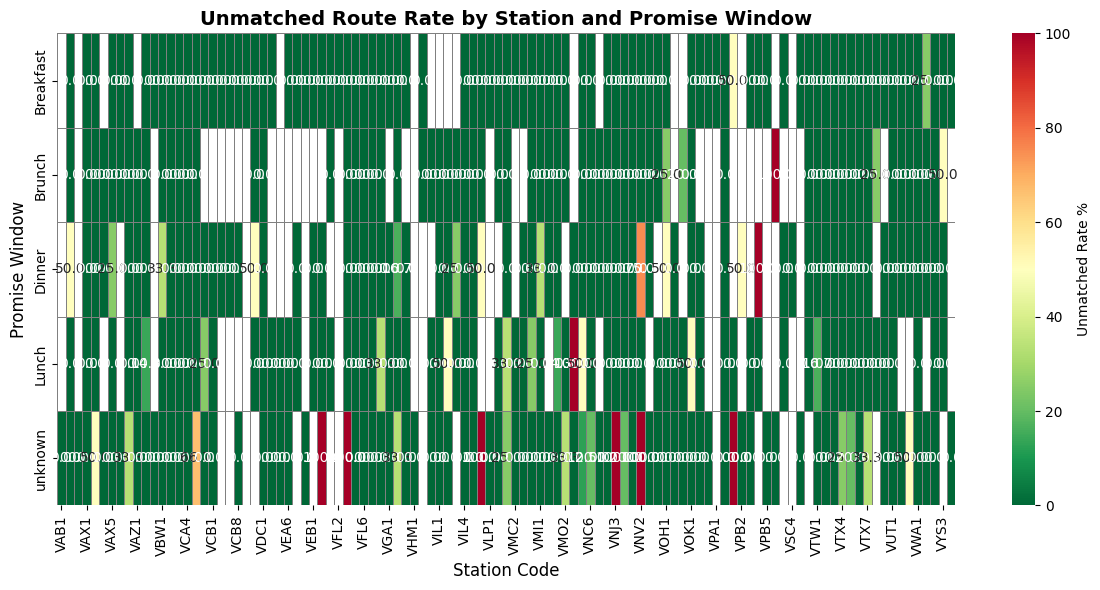

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Filter for unmatched routes
unmatched_df = df[df['matching'] == 'unmatched'].copy()

# Create match rate heatmap
match_rate = df.groupby(['station_code', 'promise_window']).agg({
    'planned_route_id': 'count',
    'matching': lambda x: (x == 'unmatched').sum()
}).reset_index()
match_rate['unmatch_rate_%'] = (match_rate['matching'] / match_rate['planned_route_id'] * 100).round(1)

pivot_match = match_rate.pivot(index='promise_window', columns='station_code', values='unmatch_rate_%')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_match, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            vmin=0, vmax=100, cbar_kws={'label': 'Unmatched Rate %'},
            linewidths=0.5, linecolor='gray')
plt.title('Unmatched Route Rate by Station and Promise Window', fontsize=14, fontweight='bold')
plt.xlabel('Station Code', fontsize=12)
plt.ylabel('Promise Window', fontsize=12)
plt.tight_layout()
plt.show()

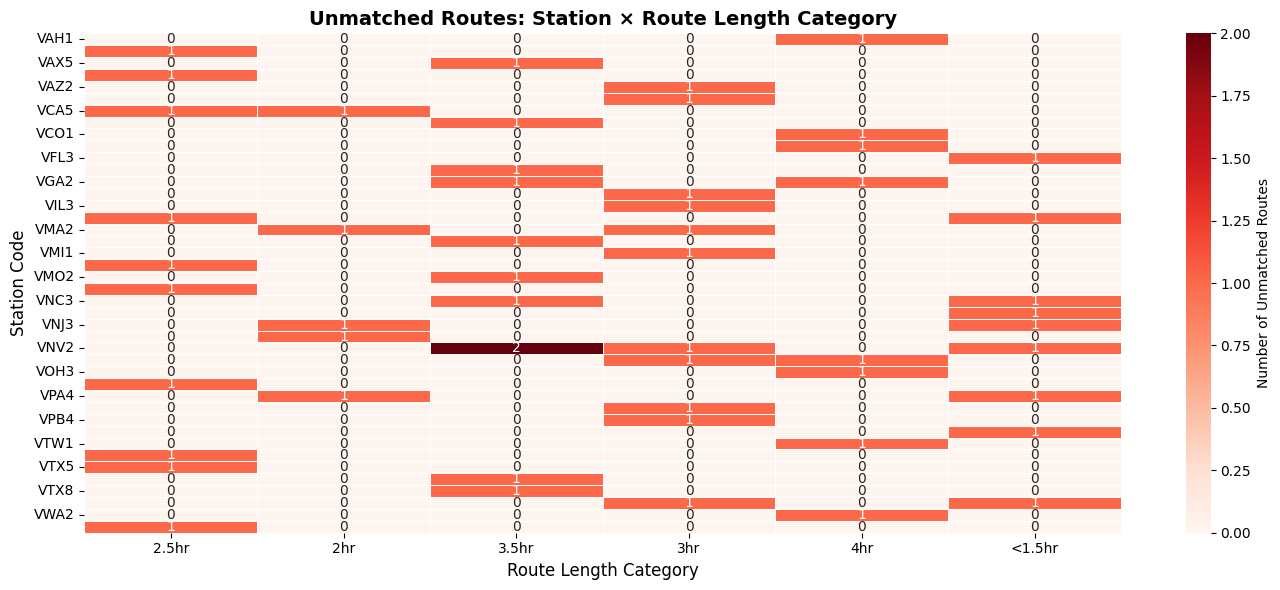

In [27]:
# Unmatched routes by station and route length
unmatched_length = unmatched_df.groupby(['station_code', 'route_length_category']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(unmatched_length, annot=True, fmt='d', cmap='Reds', 
            cbar_kws={'label': 'Number of Unmatched Routes'},
            linewidths=0.5, linecolor='white')
plt.title('Unmatched Routes: Station × Route Length Category', fontsize=14, fontweight='bold')
plt.xlabel('Route Length Category', fontsize=12)
plt.ylabel('Station Code', fontsize=12)
plt.tight_layout()
plt.show()

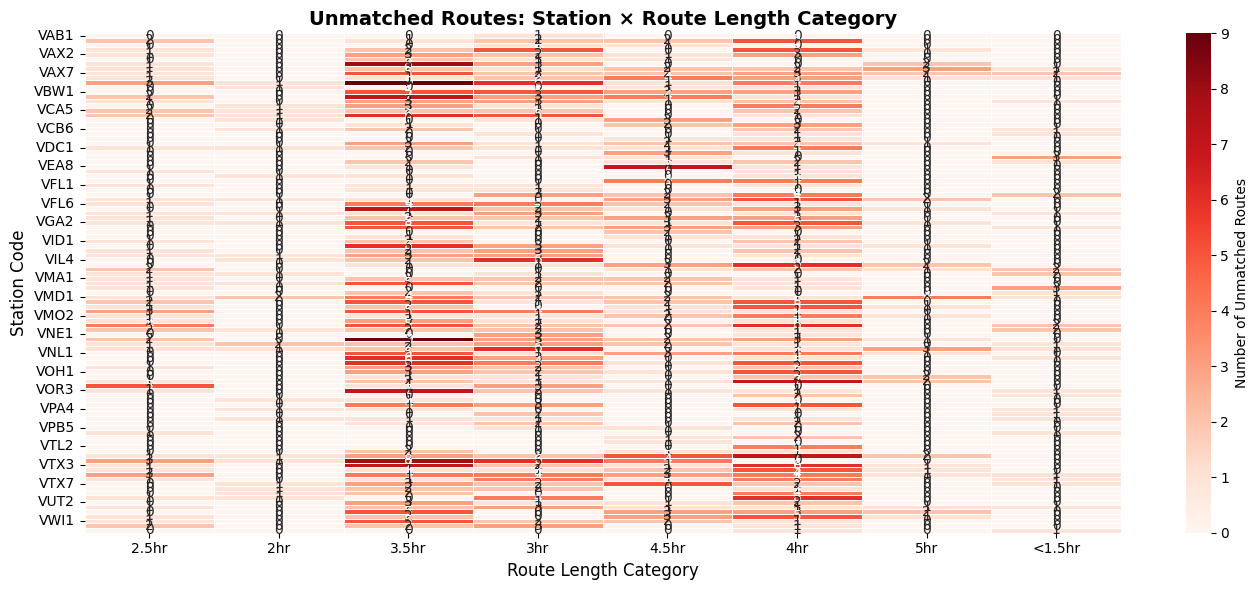

In [18]:
# Unmatched routes by station and route length
unmatched_length = df.groupby(['station_code', 'route_length_category']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(unmatched_length, annot=True, fmt='d', cmap='Reds', 
            cbar_kws={'label': 'Number of Unmatched Routes'},
            linewidths=0.5, linecolor='white')
plt.title('Unmatched Routes: Station × Route Length Category', fontsize=14, fontweight='bold')
plt.xlabel('Route Length Category', fontsize=12)
plt.ylabel('Station Code', fontsize=12)
plt.tight_layout()
plt.show()

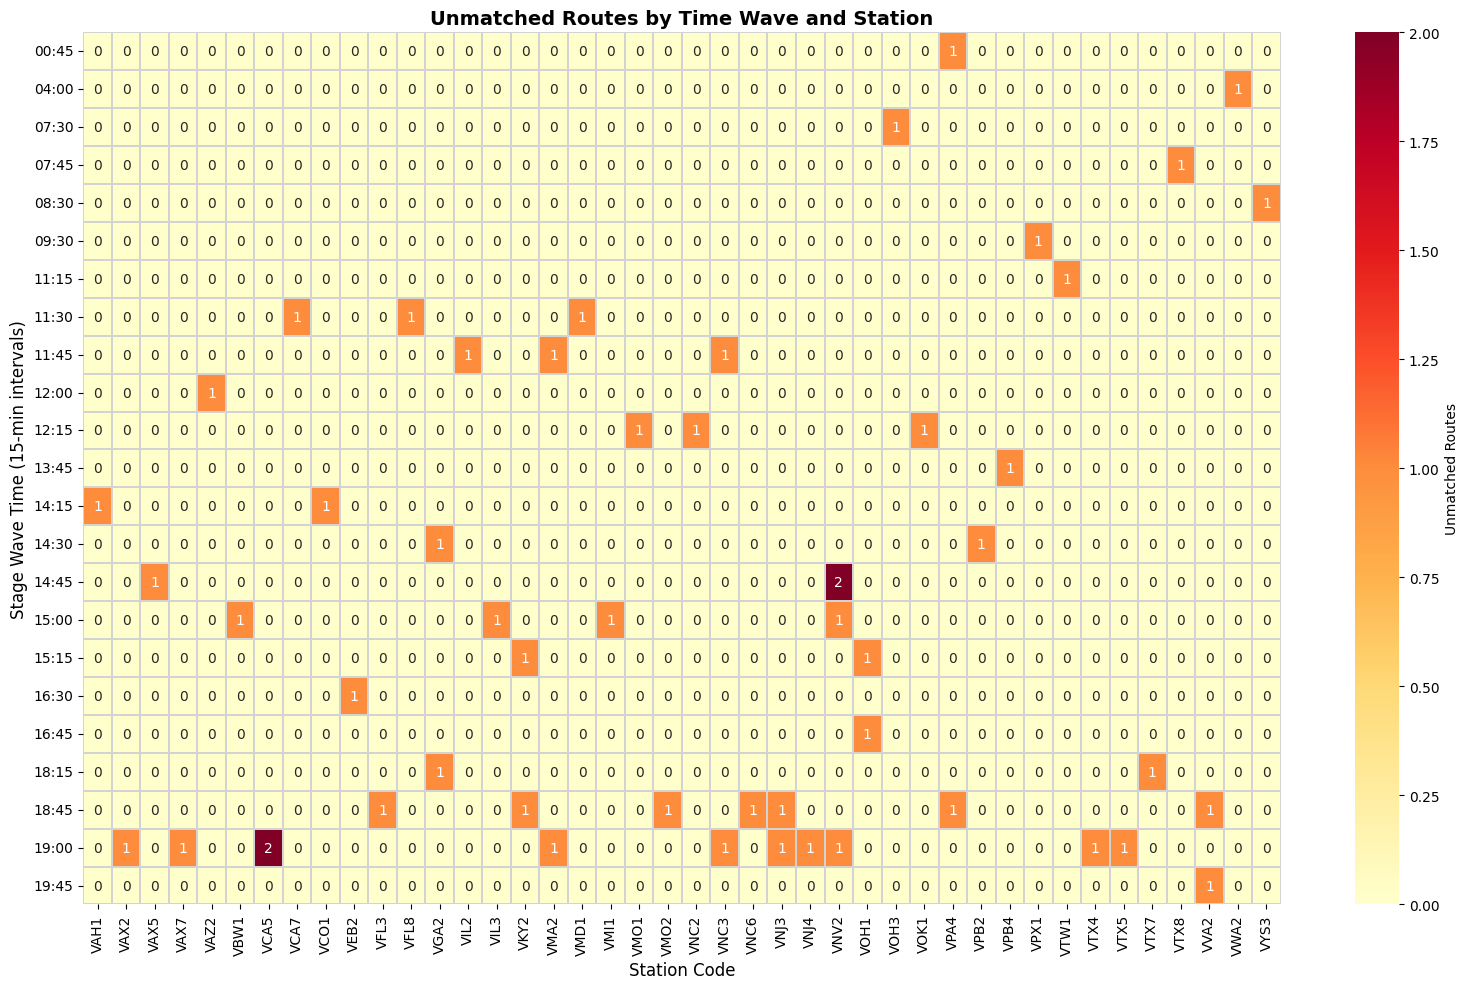

In [28]:
# Extract hour and wave for better visualization
unmatched_df['stage_hour'] = unmatched_df['route_stage_wave_time'].dt.hour
unmatched_df['stage_wave'] = unmatched_df['route_stage_wave_time'].dt.strftime('%H:%M')

# Count unmatched by time and station
time_station = unmatched_df.groupby(['stage_wave', 'station_code']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 10))
sns.heatmap(time_station, cmap='YlOrRd', annot=True, fmt='d',
            cbar_kws={'label': 'Unmatched Routes'},
            linewidths=0.3, linecolor='lightgray')
plt.title('Unmatched Routes by Time Wave and Station', fontsize=14, fontweight='bold')
plt.xlabel('Station Code', fontsize=12)
plt.ylabel('Stage Wave Time (15-min intervals)', fontsize=12)
plt.tight_layout()
plt.show()